 The following standard libraries are required for this code.

In [120]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema


 Define a simple harmonic function:
$F_{\mathrm{host (harmonic)}} = \frac{1}{2}k(w-c)^2$

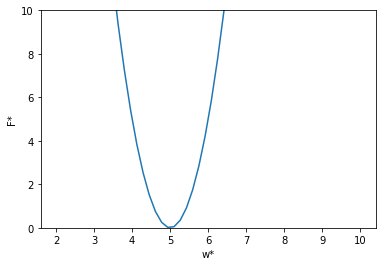

In [121]:
def harmonic(w, x1, k):
    return 0.5*k*(w-x1)**2

k = 10
min_harm = 5
examplewidths = np.linspace(2,10)
plt.plot(examplewidths,harmonic(examplewidths,min_harm,k), color="C0")
plt.ylim([0,10])
plt.xlabel("w*")
plt.ylabel("F*")
plt.show()


 and a double well function:
$F_{\mathrm{host (bistable)}} = c_1(w-c_2)^4 - c_3(w-c_4)^2 + c_5(w-c_6)$

In [122]:
def free_energy(w, x1, x2, E1, E2, E3):
    f1 = E1+(E2 - E1)*(w-x1)/(x2-x1)
    h1 = (w - x1)**2 * (w-x2) * (E1-E2)/(x2-x1)**3
    h2 = (w - x1) * (w-x2)**2 * (E1-E2)/(x2-x1)**3
    k1 = (2.0/(x2 - x1))**4 * ((E3-E1) + (E1-E2)/2 - (E1-E2)/8 - (E1-E2)/8)
    g1 = k1 * (w - x1)**2 * (w - x2)**2
    return f1+h1+h2+g1


 which can produce a free energy profile where a material is more stable in narrow pore state

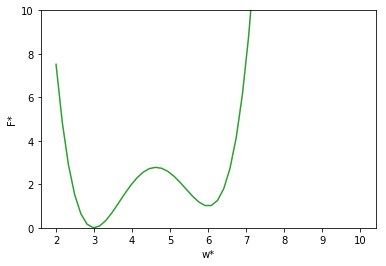

In [123]:
min1 = 6
min2 = 3
min1_depth = 1
min2_depth = 0
Fe_barrier =  3
examplewidths = np.linspace(2,10)
plt.plot(examplewidths,free_energy(examplewidths,min1, min2, min1_depth, min2_depth, Fe_barrier), color="C2")
plt.ylim([0,10])
plt.xlabel("w*")
plt.ylabel("F*")
plt.show()


 or more stable in an open pore state

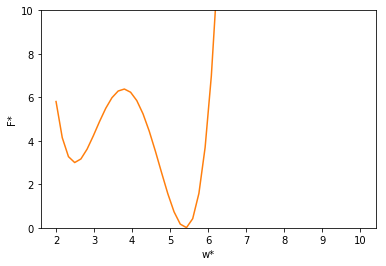

In [124]:
min1 = 2.5
min2 = 5.4
min1_depth = 3
min2_depth = 0
Fe_barrier =  7
examplewidths = np.linspace(2,10)
plt.plot(examplewidths,free_energy(examplewidths,min1, min2, min1_depth, min2_depth, Fe_barrier), color="C1")
plt.ylim([0,10])
plt.xlabel("w*")
plt.ylabel("F*")
plt.show()


 We can then combine these fee energy functions, which describe the flexibility of a slit-pore. with the grand potential of adsorption to find the total osmotic potential of the system.
$$\Omega_{\mathrm{os}}(T,P,w) = F_{\mathrm{host}} + PV + \Omega(T,P,w)$$
 We obtain $\Omega(T,P,w)$ from a kernel of isotherms simulated by density functional theory which can be loaded from panda dataframes. Each case corresponds to a different temperature 0.8 T, 1.31 T and 2.0 T for case 1-3, respectively.

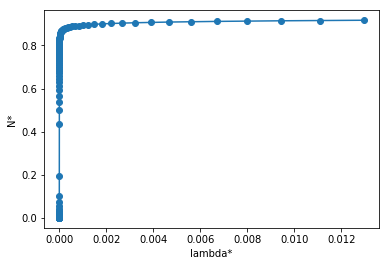

In [125]:
data_eq = pd.read_pickle("/Users/jevans/Documents/GitHub/supp-data/10.26434_chemrxiv.7527680/kernel_data/case1_eq.pickle")

#lets just check this actually contains an isotherm

#filter for 1 width
width2 = data_eq[data_eq["!w"]==2.0]
#plot
plt.plot(width2["lambda*"], width2["Ads"], 'o-', color="C0")
plt.xlabel("lambda*")
plt.ylabel("N*")
plt.show()


To generate an isotherm we need to find the minimum of $\Omega_{\mathrm{os}}$ with the added constraint that the maximum energy between a current local minimum and lower energy minimum is less than some threshold value ($\Omega_{\mathrm{crit}}$)

In [126]:
#defined for a bistable function
def get_eq_isotherm_bistable(min1, min2, min1_depth, min2_depth, Fe_barrier, os_crit, data_eq, T):
    data_eq["osmotic"] = free_energy(data_eq["!w"], min1, min2, min1_depth, min2_depth, Fe_barrier)+data_eq["Omega"]*T+data_eq["P*"]*data_eq["!w"]

    acts = data_eq["lambda*"].unique()
    widths = data_eq["!w"].unique()

    #find width for empty structure
    free_energy_bare = free_energy(widths, min1, min2, min1_depth, min2_depth, Fe_barrier)
    min_width_bare = widths[np.argmin(free_energy_bare)]
    current_width = min_width_bare
    #initialise lists of activity (xs), number adsorbed (ys) and current widths (zs)  
    xs = []
    ys = []
    zs = []
    #loop over activity to make an iostherm
    count=0
    for act in acts:
        data_lambda = data_eq[data_eq["lambda*"] == act]

        #calculate minima on the osmotic vs w surface
        minima = data_lambda.iloc[argrelextrema(data_lambda["osmotic"].values, np.less, mode='wrap')[0]]
        minima_idx = minima.index.values
        #for each minima check if another minima is lower (or same energy) and if the barrier is equal to or below Os_crits
        for min in minima_idx:
            current_idx = minima[minima['!w'] == current_width].index.values
            if min != current_idx:
                width_other = minima['!w'][min]
                if  width_other < current_width:
                    if minima[minima['!w'] == width_other]["osmotic"].values <= minima[minima['!w'] == current_width]["osmotic"].values:
                        osmotic_max = max(data_lambda[data_lambda['!w'].between(width_other, current_width, inclusive=True)]["osmotic"].values)
                        if osmotic_max-minima[minima['!w'] == current_width]["osmotic"].values[0] <= os_crit:
                            current_width = width_other

                if  width_other > current_width:
                    if minima[minima['!w'] == width_other]["osmotic"].values <= minima[minima['!w'] == current_width]["osmotic"].values:
                        osmotic_max = max(data_lambda[data_lambda['!w'].between(current_width, width_other, inclusive=True)]["osmotic"].values)
                        if osmotic_max-minima[minima['!w'] == current_width]["osmotic"].values[0] <= os_crit:
                            current_width = width_other

        xs.append(float(data_lambda[data_lambda["!w"] == current_width]["lambda*"].values[0]))
        ys.append(float(data_lambda[data_lambda["!w"] == current_width]["Ads"].values[0]))
        zs.append(float(data_lambda[data_lambda["!w"] == current_width]["!w"].values[0]))
    return [xs, ys, zs]

#and for a harmonic free energy function
def get_eq_isotherm_harmonic(minimum, k, os_crit, data_eq, T):
    data_eq["osmotic"] = harmonic(data_eq["!w"], minimum, k)+data_eq["Omega"]*0.8+data_eq["P*"]*data_eq["!w"]

    acts = data_eq["lambda*"].unique()
    widths = data_eq["!w"].unique()

    #find width for empty structure
    free_energy_bare = harmonic(widths, minimum, k)
    min_width_bare = widths[np.argmin(free_energy_bare)]
    current_width = min_width_bare
    #initialise lists of activity (xs), number adsorbed (ys) and current widths (zs)  
    xs = []
    ys = []
    zs = []
    #loop over activity to make an iostherm
    count=0
    for act in acts:
        data_lambda = data_eq[data_eq["lambda*"] == act]

        #calculate minima on the osmotic vs w surface
        minima = data_lambda.iloc[argrelextrema(data_lambda["osmotic"].values, np.less)[0]]
        minima_idx = minima.index.values
        #for each minima check if another minima is lower (or same energy) and if the barrier is equal to or below Os_crits
        for min in minima_idx:
            current_idx = minima[minima['!w'] == current_width].index.values
            if min != current_idx:
                width_other = minima['!w'][min]
                if  width_other < current_width:
                    if minima[minima['!w'] == width_other]["osmotic"].values <= minima[minima['!w'] == current_width]["osmotic"].values:
                        osmotic_max = max(data_lambda[data_lambda['!w'].between(width_other, current_width, inclusive=True)]["osmotic"].values)
                        if osmotic_max-minima[minima['!w'] == current_width]["osmotic"].values[0] <= os_crit:
                            current_width = width_other

                if  width_other > current_width:
                    if minima[minima['!w'] == width_other]["osmotic"].values <= minima[minima['!w'] == current_width]["osmotic"].values:
                        osmotic_max = max(data_lambda[data_lambda['!w'].between(current_width, width_other, inclusive=True)]["osmotic"].values)
                        if osmotic_max-minima[minima['!w'] == current_width]["osmotic"].values[0] <= os_crit:
                            current_width = width_other

        xs.append(float(data_lambda[data_lambda["!w"] == current_width]["lambda*"].values[0]))
        ys.append(float(data_lambda[data_lambda["!w"] == current_width]["Ads"].values[0]))
        zs.append(float(data_lambda[data_lambda["!w"] == current_width]["!w"].values[0]))
    return [xs, ys, zs]


 Lets demonstrate that this approach can simulate a negative gas adsorption processes.

/Users/jevans/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


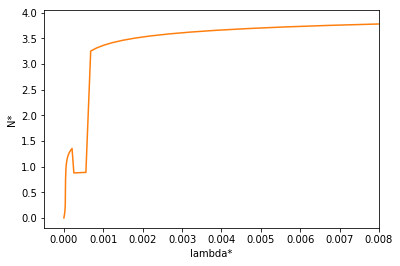

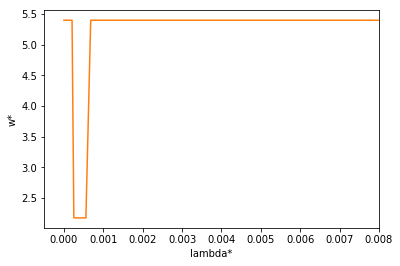

In [127]:
#input some parameters for a host free energy function
min1 = 2.5
min2 = 5.4
min1_depth = 3
min2_depth = 0
Fe_barrier =  7
T = 0.8
os_crit=6*T
# import the kernel for T*=0.8
data_eq = pd.read_pickle("/Users/jevans/Documents/GitHub/supp-data/10.26434_chemrxiv.7527680/kernel_data/case1_eq.pickle")

output = get_eq_isotherm_bistable(min1, min2, min1_depth, min2_depth, Fe_barrier, os_crit,  data_eq, T)



#for example plot an isotherm
plt.plot(output[0],output[1], color="C1")
plt.xlabel("lambda*")
plt.ylabel("N*")
plt.xlim([-0.0005,0.008])
plt.show()
#and the change in pore width
plt.plot(output[0],output[2], color="C1")
plt.xlabel("lambda*")
plt.ylabel("w*")
plt.xlim([-0.0005,0.008])
plt.show()